# 1. k-Nearest Neighbors

## 1.1. The algorithm
[$k$-NN](https://scikit-learn.org/stable/modules/neighbors.html#classification) ($k$-Nearest Neighbors) first measures the distance from each observation $\mathbf{o}_i=(x_{1i},x_{2i},\dots)$ to the query point $\mathbf{o}_q=(x_{1q},x_{2q},\dots)$. Then it selects $k$ observations with smallest distances; these points fall into several classes. Finally, do majority voting or weighted voting to determine which class the query point belongs to. For weighted voting, the query point will fall into the class with the highest total of weight. The weight of each observation is $\displaystyle{w_i=1/d_i}$.

Some popular distance metrics being used in $k$-NN are:
- [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry): measures the total distance of going along side every axis
- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance): measures the direct distance
- [Mahalanobis distance](https://en.wikipedia.org/wiki/Mahalanobis_distance): same as Euclidean but variables are scaled and transformed to be uncorrelated

However, Euclidean distance is the most common method:

$$d_i = \sqrt{(x_{1i}-x_{1q})^2+(x_{2i}-x_{2q})^2+\dots}$$

## 1.2. Implementation
Notable hyperparameters in [$k$-NN implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html):

Hyperparameter|Meaning|Default value|Common values|
:---|:---|:---|:---|
`n_neighbors`|Number of nearest neighbors|`5`||
`weights`|Majority voting or weighted voting|`uniform`|`uniform` `distance`|
`metrics`|Distance metric|`euclidean`|`euclidean` `manhattan` `mahalanobis`|

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df = df.assign(species=iris.target)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [3]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [4]:
X = iris.data
y = iris.target

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [6]:
params = {
    'n_neighbors': np.arange(2, 22),
    'weights': ['uniform', 'distance'],
    'metric': ['manhattan', 'euclidean']
}

knn = KNeighborsClassifier()
knn = GridSearchCV(knn, params, cv=5, scoring='accuracy')
knn = knn.fit(X_train, y_train)

knn.best_params_

{'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'uniform'}

In [7]:
y_train_pred = knn.predict(X_train)
y_test_pred = knn.predict(X_test)

In [8]:
matrix = confusion_matrix(y_train, y_train_pred, labels=[0, 1, 2])
pd.DataFrame(matrix, columns=iris.target_names, index=iris.target_names)

,setosa,versicolor,virginica
setosa,36,0,0
versicolor,0,30,2
virginica,0,1,36


In [9]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.94      0.95        32
           2       0.95      0.97      0.96        37

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



In [10]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.94      0.94        18
           2       0.92      0.92      0.92        13

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



# 2. Decision Tree

## 2.1. The algorithm
[Decision Tree](https://scikit-learn.org/stable/modules/tree.html#tree) is an algorithm aiming to find a set of if-else statements, visualized as a hierarchy diagram.

### Composition of a tree
In a tree, a node is the representation of data. The data is then split using a variable. A node is a parent node if it is split, the smaller nodes after splitting it are child nodes. Here is the composition of a tree:
- Root node: the topmost node, represents the entire data
- Leaf node: the node that is not split further and predicts the labels
- Non-leaf node: any node other than leaf nodes
- Branch: the specific criteria to split a node

### Recursive splitting
The overall idea of Decision Tree is to decide which variable should be used in splitting data at each node. We would expect a split that results in pure/homogeneous branches, since it will be much easier to classify data in such branches.
- Starting at the root node $\mathbf{D}$, we are finding a variable that best splits the data. Consider a candidate $\mathbf{x}$, possible values of $\mathbf{x}$ are $x_1,x_2,\dots$ The split of $\mathbf{D}$ on $\mathbf{x}$ (denoted $\mathbf{D}|\mathbf{x}$) outputs child nodes $\mathbf{D}|x_1,\mathbf{D}|x_2,\dots$

- Measure the impurity for each candidate, using Entropy or Gini index. The split with the lowest impurity will be chosen.

- This procedure is recursively repeated until all leaf nodes are pure enough to classify. A couple of stopping criteria can be added to prevent the tree from being too complex, which may cause overfitting.

### Measures of impurity
Let's say at a node, the data has the possible labels of $y_1,y_2,\dots$ The probability that an observation falls into the class $y_i$ is $p_i$. Here are the two measures of impurity's formula:

- $\displaystyle{\mbox{Entropy} = -\sum{p_i\ln{p_i}}}$

- $\displaystyle{\mbox{Gini} = 1-\sum{p_i^2}}$

For the split $\mathbf{D}|\mathbf{x}$, the Entropy or Gini index is calculated by taking the proportional sum of Entropy/Gini index of child nodes. The lower the Entropy or Gini index, the purer the data is. If all the instances are of a single class, both Entropy and Gini index reach 0.

## 2.2. Implementation
Notable hyperparameters in [Decision Tree implementation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):

Hyperparameter|Meaning|Default value|Common values|
:---|:---|:---|:---|
`criterion`|Measure of impurity|`gini`|`entropy` `gini`|
`max_depth`|Max depth of the tree|`None`||
`max_leaf_nodes`||||
`min_impurity_split`|The threshold that nodes no longer split|`0`|`0.1` `0.2`|
`min_impurity_decrease`||||
`min_samples_split`|The min number of instances in a node to split|`2`||
`min_samples_leaf`|The min number of instances of a node to be a leaf|||
`min_weight_fraction_leaf`||||

In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, classification_report

In [12]:
credit = pd.read_csv('data/credit_scoring.csv')
credit = credit.dropna().reset_index()
credit.head()

,index,bad_customer,credit_balance_percent,age,num_of_group1_pastdue,debt_ratio,income,num_of_loans,num_of_times_late_90days,num_of_estate_loans,num_of_group2_pastdue,num_of_dependents
0,0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [13]:
y = credit.bad_customer.values
X = credit.drop(columns='bad_customer')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [15]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1,10),
}

tree = DecisionTreeClassifier()
tree = GridSearchCV(tree, params, cv=5)
tree = tree.fit(X_train, y_train)

tree.best_params_

{'criterion': 'entropy', 'max_depth': 5}

In [16]:
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

In [17]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     89525
           1       0.59      0.19      0.28      6690

    accuracy                           0.93     96215
   macro avg       0.77      0.59      0.62     96215
weighted avg       0.92      0.93      0.92     96215



In [18]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     22387
           1       0.54      0.17      0.26      1667

    accuracy                           0.93     24054
   macro avg       0.74      0.58      0.61     24054
weighted avg       0.91      0.93      0.92     24054



### Interpreting
A max depth of 3 is selected for better visualization. Each color represents a class, dark color nodes are the purest ones. In contrast, it's very hard to make a decision for bright nodes.

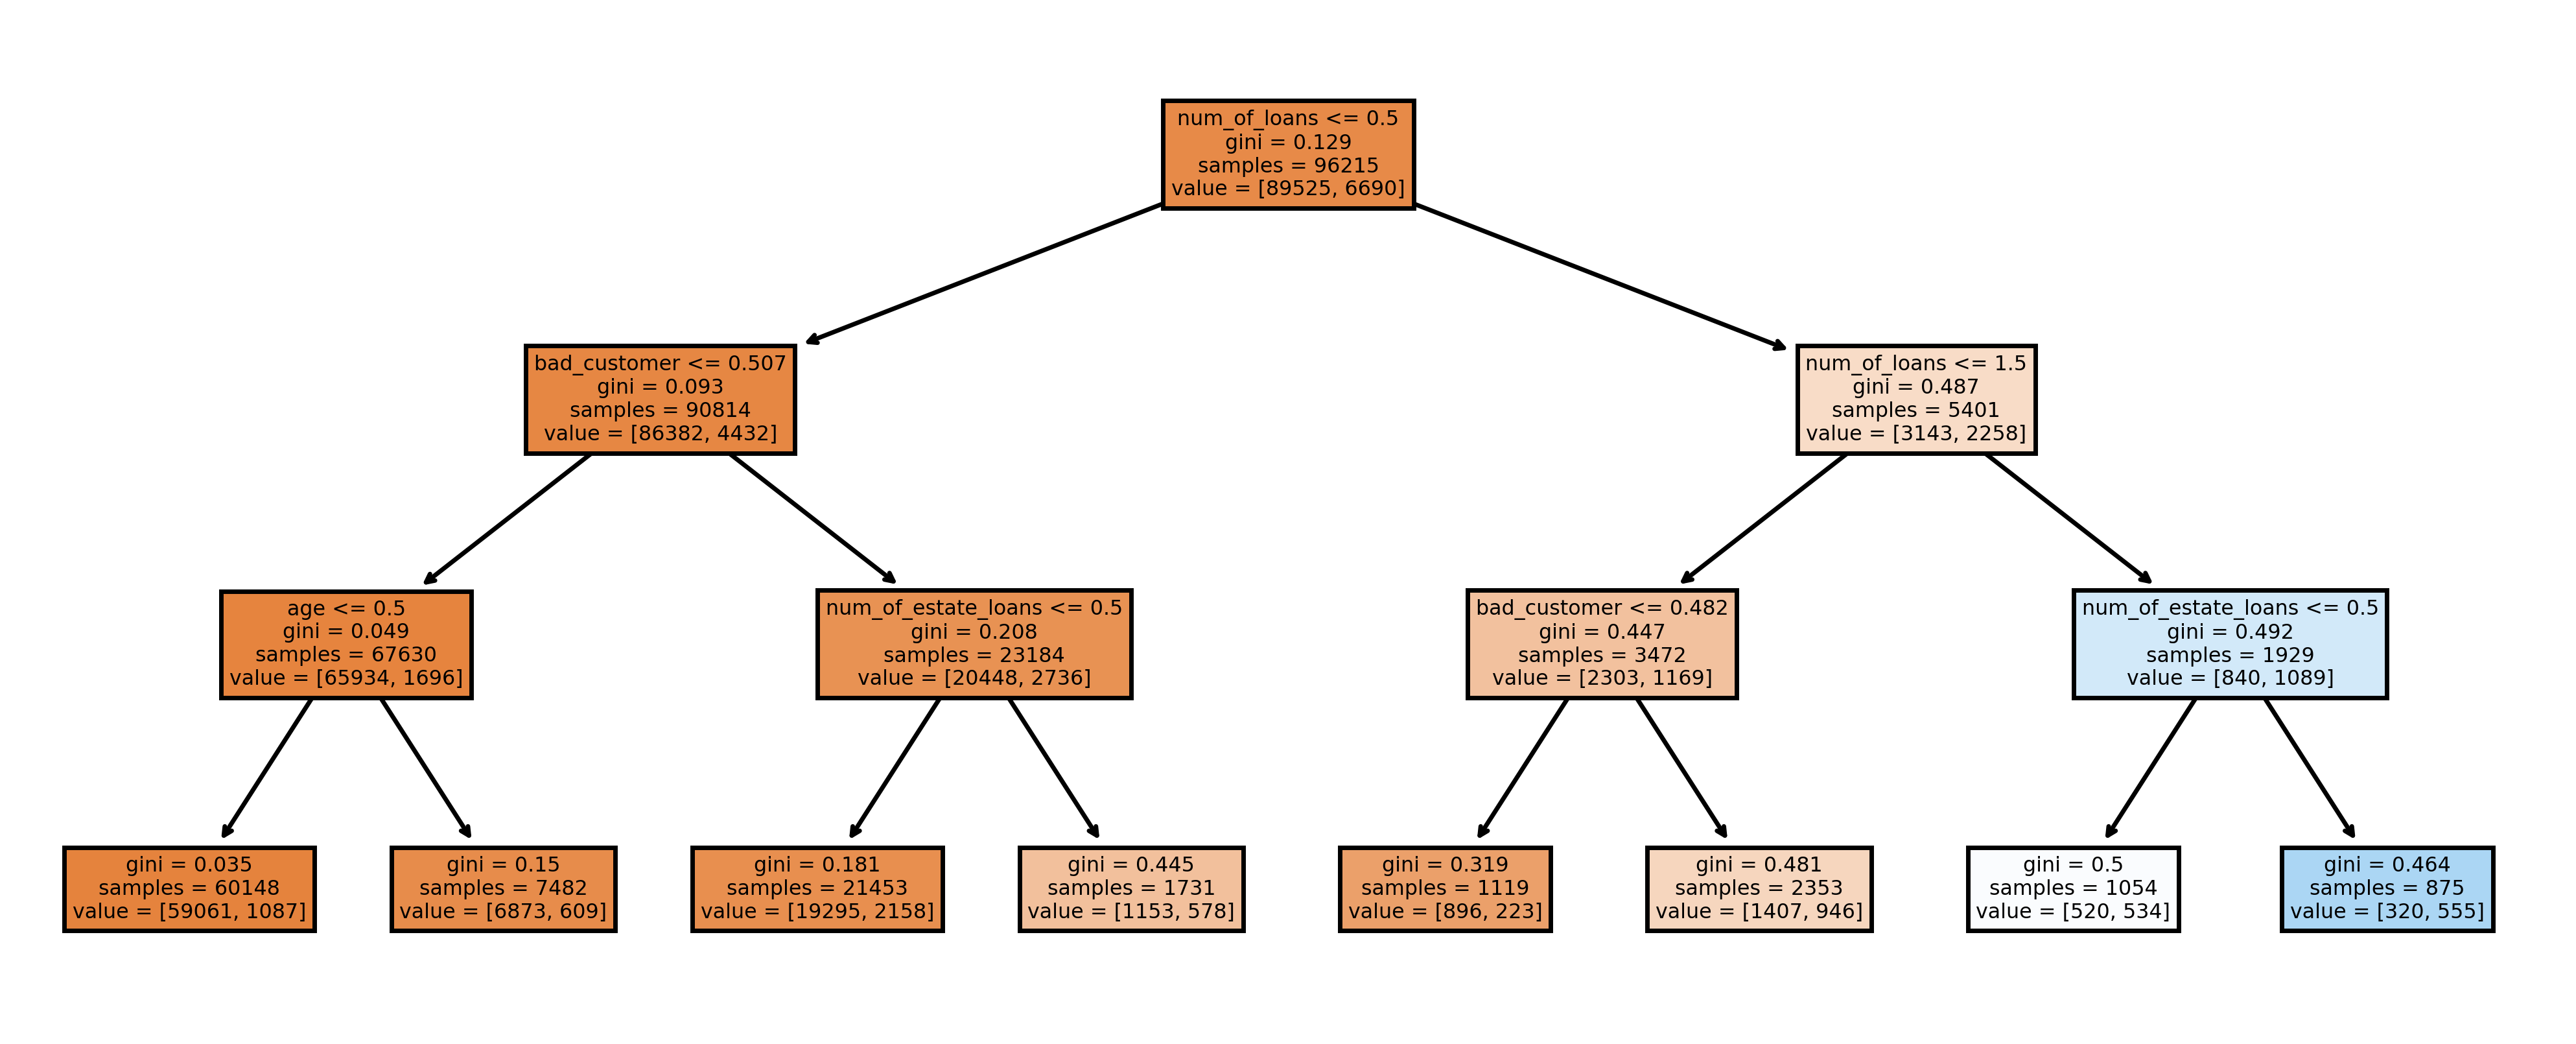

In [19]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=3)
tree = tree.fit(X_train, y_train)

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4), dpi=500)
plot_tree(tree, feature_names=credit.columns.values, filled=True)
plt.show()

# 3. Naive Bayes

## 3.1. The algorithm
[Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) is an algorithm based on the [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem). In the context of classification, given $\mathbf{X}=\mathbf{x}_1,\mathbf{x}_2,\dots$ is the set of input variables and $\mathbf{y}$ is the output variable; the Bayes theorem can be written as:

$$P(\mathbf{y}|\mathbf{X}) = \frac{P(\mathbf{X}|\mathbf{y})P(\mathbf{y})}{P(\mathbf{X})}$$

- $P(\mathbf{y}|\mathbf{X})$ is the posterior probability, the probability of a class for given predictors
- $P(\mathbf{X}|\mathbf{y})$ is the likelihood, the probability of predictors for a given class
- $P(\mathbf{y})$ is the prior probability of a class
- $P(\mathbf{X})$ is the prior probability of predictors

This formula expresses how the algorithm classifies a new query point to the class $c$:

$$\hat{\mathbf{y}} = \arg\max P(\mathbf{y}=c|\mathbf{X}) =
\arg\max P(\mathbf{X}|\mathbf{y}=c)P(\mathbf{y}=c)$$

### Estimating the likelihood
Naive Bayes assumes that $\mathbf{x}_1,\mathbf{x}_2,\dots$ are independent of each other. This assumption looks quite unrealistic, explains why the algorithm is considered naive. However, Naive Bayes performs surprisingly well in real-world classification problems. The likelihood can be written under this assumption:

$$P(\mathbf{x}_1,\mathbf{x}_2,\dots|\mathbf{y}) = \prod{P(\mathbf{x}_i|\mathbf{y})}$$

To estimate $P(\mathbf{x}_i|\mathbf{y})$, there are three distributions can be used, depending on the input data:
- Gaussian distribution, used when the input data is continuous. The parameters $\mu_{\mathbf{y}}$ and $\sigma_{\mathbf{y}}$ are estimated using maximum likelihood.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{1}{\sqrt{2\pi\sigma^2_{\mathbf{y}}}} \exp\left(-\frac{(\mathbf{x}_i - \mu_{\mathbf{y}})^2}{2\sigma^2_{\mathbf{y}}}\right)$$

- Multinomial distribution, used when the input data is categorical data. Widely used in text classification. In this formula, $N$ represents the number of observations, $\alpha$ represents the Laplace smooth coefficient, $d$ is the number of words. $\alpha=1$ is usually chosen, prevents the probability to be 0.

$$P(\mathbf{x}_i|\mathbf{y}) = \frac{N(\mathbf{x}_i|\mathbf{y})+\alpha}{N(\mathbf{y})+\alpha d}$$

- Bernoulli distribution, used for binary input data.

$$P(\mathbf{x}_i|\mathbf{y}) = p_i^{\mathbf{x}_i}(1-p_i)^{1-\mathbf{x}_i}$$

## 3.2. Implementation

In [20]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report

### Tabular data
This section uses the Iris data, where input variables are continuous. For a mixed types dataset, we use `GaussianNB` for continuous input and `MultinomialNB` for categorical input, then multiply the predicted probability of each class.

In [21]:
iris = load_iris()
X = iris.data
y = iris.target

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [23]:
bayes = GaussianNB()
bayes = bayes.fit(X_train, y_train)

In [24]:
y_train_pred = bayes.predict(X_train)
y_test_pred = bayes.predict(X_test)

In [25]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.94      0.91      0.92        32
           2       0.92      0.95      0.93        37

    accuracy                           0.95       105
   macro avg       0.95      0.95      0.95       105
weighted avg       0.95      0.95      0.95       105



In [26]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.94      0.89      0.91        18
           2       0.86      0.92      0.89        13

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.94      0.93      0.93        45



### Text data
Text data is preprocessed so that each column represents a word, each row represents a graph. This table shows how many times a word occurs in a graph. Then apply `MultinomialNB`.

In [27]:
X_train = np.array([
    [2, 2, 1, 0, 0, 0, 0, 0, 0],
    [1, 3, 0, 1, 2, 0, 0, 0, 0],
    [0, 1, 0, 1, 1, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 2, 1, 1]
])
y_train = np.array(['A', 'A', 'A', 'B'])

X_test = np.array([
    [1, 2, 0, 1, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 0, 1, 1]
])

In [28]:
bayes = MultinomialNB()
bayes = bayes.fit(X_train, y_train)

In [29]:
bayes.predict(X_test)

array(['A', 'B'], dtype='<U1')

In [30]:
bayes.predict_proba(X_test)

array([[0.93708063, 0.06291937],
       [0.34255957, 0.65744043]])

# 4. Support Vector Machines
*Reference: [Scikit-Learn - Support Vector Machines](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)*

## 4.1. The algorithm
[Support Vector Machines](https://scikit-learn.org/stable/modules/svm.html#svm-classification) is a binary classification algorithm, aiming to find a hyperplane that best splits the data into two classes ($\mathbf{y}=1$ and $\mathbf{y}=-1$). SVM uses the following concepts:
- Support vector: the closest point from the separating hyperplane. There is at least one support vector in each class.
- Margin: the distance between a support vector and the separating hyperplane.

Notice that all support vectors should have the same distance from the decision boundary. In other words, the margins of both class are equal. It's quite clear to state that the larger the margin is, the better the algorithm classifies the data.

### The loss function
Assume the equation of the separating hyperplane is $w_0+w_1\mathbf{x}_1+w_2\mathbf{x}_2+\dots=0$. Denote $\mathbf{w}=(w_1,w_2,\dots)$ and $\mathbf{X}=(\mathbf{x}_1,\mathbf{x}_2,\dots)$, the boundary can be rewritten as $w_0+\mathbf{w}\mathbf{X}=0$. Now do some transformations so that the equations of the two edges (hyperplanes that are parallel to the boundary and go through the support vectors) are $w_0+\mathbf{w}\mathbf{X}=1$ and $w_0+\mathbf{w}\mathbf{X}=-1$.

<img src='image/svm_hard.png' style='height:300px; margin: 0 auto;'>

By assigning suitable class values (for example, $\mathbf{y}=1$ for blue class and $\mathbf{y}=-1$ for red class), we have the following important property, which becomes the constraint for the margin formula:
- $|w_0+\mathbf{w}\mathbf{X}|=\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})=1$ for support vectors
- $|w_0+\mathbf{w}\mathbf{X}|=\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})>1$ for other data points

The margin can be calculated using the formula:

$$\frac{\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})}{||\mathbf{w}||_2}
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1$$

Notice that $\mathbf{y}\;(w_0+\mathbf{w}\mathbf{X})=1$ and the objective of SVM is to maximize the margin, so the loss function is selected:

$$L(w_0,\mathbf{w}) = ||\mathbf{w}||_2
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1$$

The coefficients of the separating equation $(w_0,\mathbf{w})$ can be estimated as: $(\hat{w}_0,\hat{\mathbf{w}}) = \arg\min{L(w_0,\mathbf{w})}$.

### Soft Margin SVM
In the simple example above, the line segregates perfectly; however a hard margin like that is very sensitive to outliers and can easily lead to overfitting. This can be avoided by allowing some misclassified points to get a larger margin, and thus return a better long run performance.

To get the soft margin, we soften the constrain of the margin formula:

$$\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1-\boldsymbol{\xi}$$

$\boldsymbol{\xi}=(\xi_1,\xi_2,\dots)$ is the slack variable, which is the distance from a data point in the wrong side to its corresponding edge, and is 0 otherwise. Mathematically:
- $\boldsymbol{\xi}=0$ if a data point is in the safe zone
- $\boldsymbol{\xi}=|w_0+\mathbf{w}\mathbf{X}-\mathbf{y}|<1$ if a data point is correctly classified but lies within the margin
- $\boldsymbol{\xi}=|w_0+\mathbf{w}\mathbf{X}-\mathbf{y}|\geq1$ if a data point is in the wrong side of separating hyperplane

<img src='image/svm_soft.png' style='height:300px; margin: 0 auto;'>

The loss function of Soft Margin SVM adds a regularization amount:

$$L(w_0,\mathbf{w}) = ||\mathbf{w}||_2+C\sum{\boldsymbol{\xi}}
\quad\text{subject to:}\;\mathbf{y}\,(w_0+\mathbf{w}\mathbf{X})\geq 1-\boldsymbol{\xi}$$

$C$ is the regularization parameter, it maintains the trade-off between the misclassifications and how large the margin is. When $C$ is very large, $\sum{\boldsymbol{\xi}}$ approaches 0, the algorithm is now using hard margin. In contrast, a small value of $C$ allows more data to be within the margin. A popular value of $C$ is $1/n$.

### Kernel SVM
Soft Margin SVM only works on linear separable data. When the data is non-linear, we project the data to a higher dimensional space. For example, mapping $(\mathbf{x}_1,\mathbf{x}_2)$ to $(\mathbf{x}_1,\mathbf{x}_2,\mathbf{x}_3)$ where $\mathbf{x}_3=\mathbf{x}_1^2+\mathbf{x}_2^2$ seems a good strategy.

<img src='image/svm_kernel.png' style='height:300px; margin: 0 auto;'>

However, transforming data directly may require a lot of computation, and becomes impossible when infinite dimensional is used. This problem can be avoided thanks to a technique called the kernel trick. It calculates the dot product of two transformed vectors, which represents their relationship in higher dimensional space. Depending on the problem, there are many kernel functions can be used:
- Linear kernel: $K(\mathbf{a},\mathbf{b})=\mathbf{a}\mathbf{b}$
- Polynomial kernel: $K(\mathbf{a},\mathbf{b})=(\gamma\mathbf{a}\mathbf{b}+r)^d$
- Radial Basic Function kernel: $K(\mathbf{a},\mathbf{b})=\exp{\left(-\gamma||\mathbf{a}-\mathbf{b}||_2^2\right)}$
- Sigmoid kernel: $\tanh{(\gamma\mathbf{a}\mathbf{b}+r)}$

## 4.2. Implementation
Notable hyperparameters in [SVM implementation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html):

Hyperparameter|Meaning|Default value|Common values|
:---|:---|:---|:---|
`C`|How significant the penalty is|`1`|`10^k` for $k\in{\{-2,-1,0,1,2\}}$|
`kernel`|The kernel function to be used|`rbf`|`rbf` `poly` `sigmoid`|
`gamma`|The parameter $\gamma$ in some kernels|`scale`|`10^k` for $k\in{\{-2,-1,0,1,2\}}$|
`coef0`|The parameter $r$ in some kernels|`0`||
`degree`|The degree $d$ in polynomial kernel|`3`||

In [31]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [32]:
iris = load_iris()
X = iris.data
y = iris.target

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [34]:
params = {
    'C': [0.01, 0.01, 0.1, 1, 100],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': [0.01, 0.01, 0.1, 1, 100]
}

svm = SVC()
svm = GridSearchCV(svm, params, cv=5)
svm = svm.fit(X_train, y_train)
svm.best_params_

{'C': 0.01, 'gamma': 0.1, 'kernel': 'poly'}

In [35]:
y_train_pred = svm.predict(X_train)
y_test_pred = svm.predict(X_test)

In [36]:
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.94      0.95        32
           2       0.95      0.97      0.96        37

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



In [37]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.94      0.97        18
           2       0.93      1.00      0.96        13

    accuracy                           0.98        45
   macro avg       0.98      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



# 5. Multi-layer Perceptron
*Reference: [Scikit-Learn - Multi-layer Perceptron Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)*

# 6. Gaussian Process
*Reference: [Scikit-Learn - Gaussian Process Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessClassifier.html)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*